In [14]:
import torch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

from etna.datasets import TSDataset, generate_ar_df
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.distributions.normal import Normal
from etna.models.nn.deepstate import LevelSSM, LevelTrendSSM, SeasonalitySSM
from etna.pipeline.nn_pipeline import NNPipeline
from etna.analysis import plot_forecast, plot_backtest
from etna.metrics import SMAPE
from etna.pipeline import NNPipeline
from etna.models.nn import DeepStateNetwork

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data generation

In [3]:
def generate_dataset(ssm, datetime_index, seq_length:int, horizon:int, n_groups:int, n_samples:int) -> TSDataset:
    # Parameters
    prior_mean = torch.randint(1, 100, size=(n_groups, ssm.latent_dim())).float()
    prior_std = torch.rand(size=(n_groups, ssm.latent_dim())).float()
    prior_cov = torch.diag_embed(prior_std * prior_std)
    noise_std = torch.rand(size=(n_groups * n_samples, seq_length, 1)).float()
    inovation_std = torch.rand(size=(n_groups * n_samples, seq_length, ssm.latent_dim())).float()
    
    emission_coeff = ssm.emission_coeff(datetime_index[:,:seq_length])
    transition_coeff = ssm.transition_coeff()
    innovation_coeff = ssm.innovation_coeff(datetime_index[:,:seq_length]) * inovation_std
    
    eps_latent = MultivariateNormal(torch.zeros(ssm.latent_dim()), torch.eye(ssm.latent_dim())).sample(
            (n_groups * n_samples, seq_length)
        )
    eps_observation = Normal(0, 1).sample((n_groups * n_samples, seq_length, 1))

    # Data
    l_t = MultivariateNormal(prior_mean, prior_cov).sample((n_samples, )).reshape(-1, ssm.latent_dim())
    zs = []
    for t in range(seq_length):
        z_t = (emission_coeff[:, t].unsqueeze(-1).permute(0, 2, 1) @ l_t.unsqueeze(-1)).squeeze(-1) + noise_std[:, t] * eps_observation[:, t]
        l_t = (transition_coeff @ l_t.unsqueeze(-1)).squeeze(-1) + innovation_coeff[:, t] * eps_latent[:, t]
        zs.append(z_t)
    target = torch.cat(zs, dim=1).numpy().reshape(-1)
    
    # Dataset
    df = generate_ar_df(periods=seq_length, n_segments=n_groups*n_samples, start_time="2000-01-01")
    df["target"] = target
    df_exog = generate_ar_df(periods=seq_length + horizon, n_segments=n_groups*n_samples, start_time="2000-01-01")
    df_exog["group"] = [group for sample in range(n_samples) for group in range(n_groups) for _ in range(seq_length + horizon)]
    df_exog["datetime_index"] = datetime_index.numpy().reshape(-1)
    df_exog.drop(columns=["target"], inplace=True)
    df = TSDataset.to_dataset(df)
    df_exog = TSDataset.to_dataset(df_exog)
    ts = TSDataset(df, "D", df_exog, known_future="all")
    
    return ts, prior_mean, prior_std, noise_std, inovation_std

In [4]:
n_groups = 5
n_samples = 140
seq_length = 42
horizon = 14
encoder_length = 28
ssm = SeasonalitySSM(num_seasons=7)
#datetime_index = torch.randint(1, 100, size=(n_groups * n_samples, seq_length + 1, 1)).to(torch.int64)
datetime_index = torch.Tensor(np.arange(seq_length + horizon) % 7).repeat(n_groups * n_samples, 1).to(torch.int64)
ts, prior_mean, prior_std, noise_std, inovation_std = generate_dataset(ssm, datetime_index, seq_length, horizon, n_groups, n_samples)

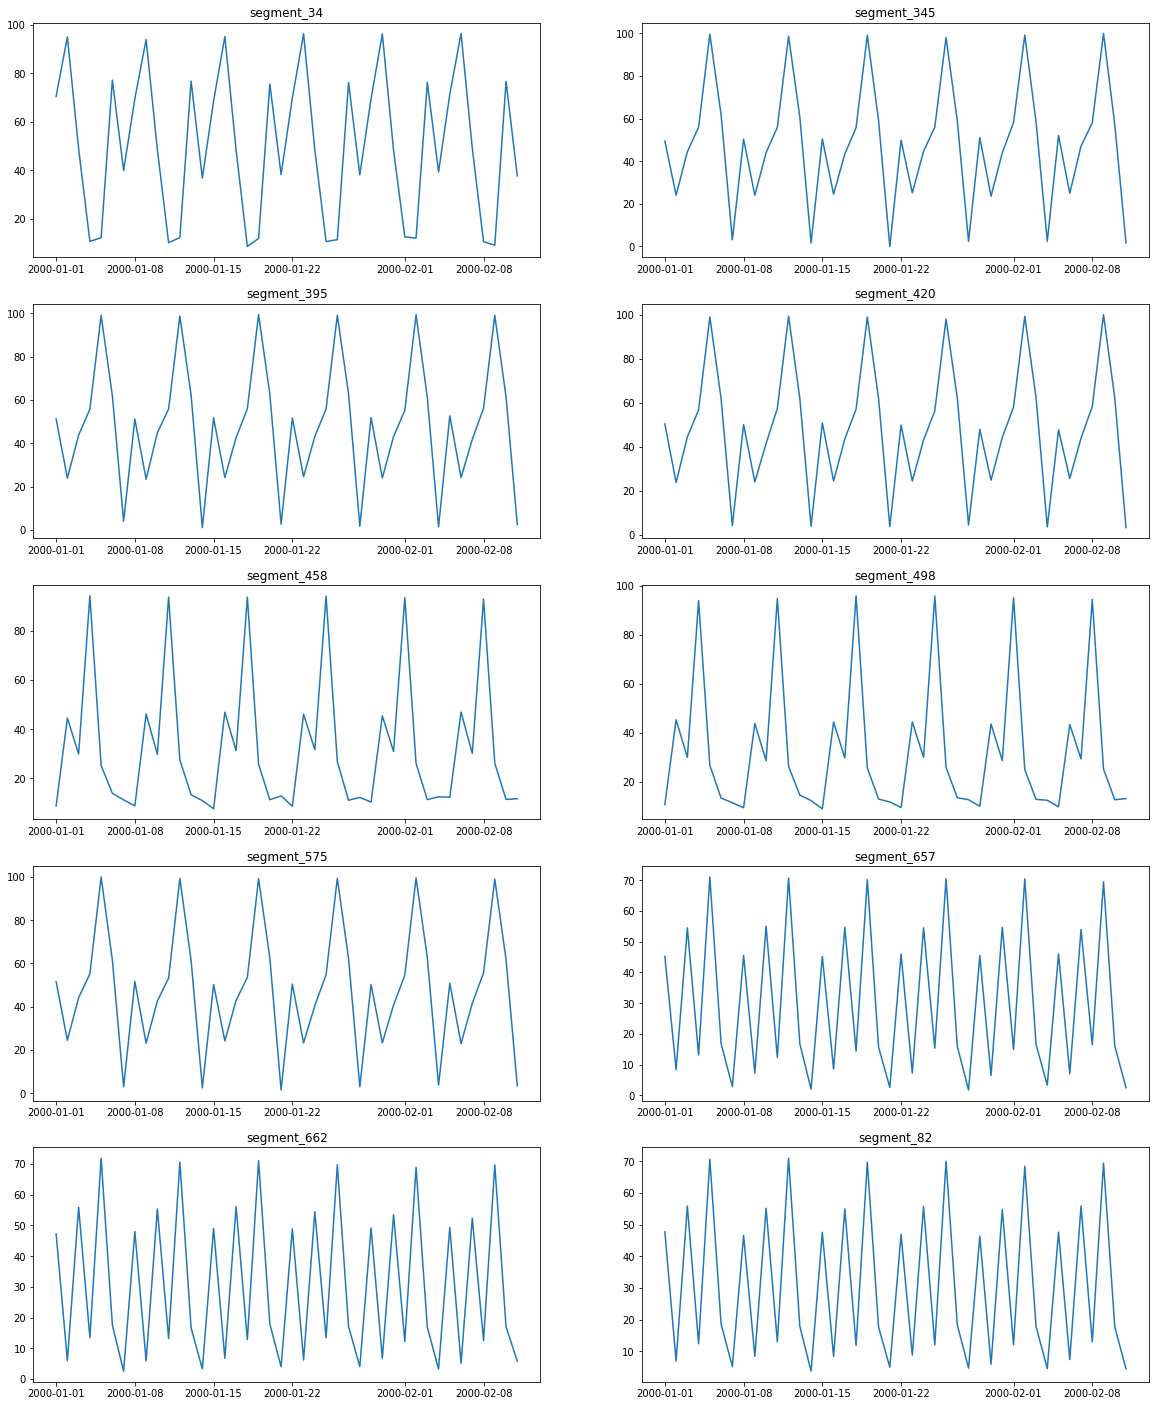

In [5]:
ts.plot(n_segments=10)

# Model

In [16]:
pipeline = NNPipeline(
        horizon=horizon,
        encoder_length=encoder_length,
        decoder_length=0,
        model=DeepStateNetwork(ssm, n_samples=10, input_size=1),
        transforms=[],
        columns_to_add=["group"],
        datetime_index="datetime_index",
        train_batch_size=32,
        test_batch_size=1,
        trainer_kwargs=dict(max_epochs=20),
    )

In [17]:
metrics, forecast, _ = pipeline.backtest(ts, metrics=[SMAPE()], n_folds=1, n_jobs=1) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name       | Type       | Params
------------------------------------------
0 | RNN        | LSTM       | 280   
1 | projectors | ModuleDict | 176   
------------------------------------------
456       Trainable params
0         Non-trainable params
456       Total params
0.002     Total estimated model params size (MB)
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/dat

Training: 0it [00:00, ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.7s finished


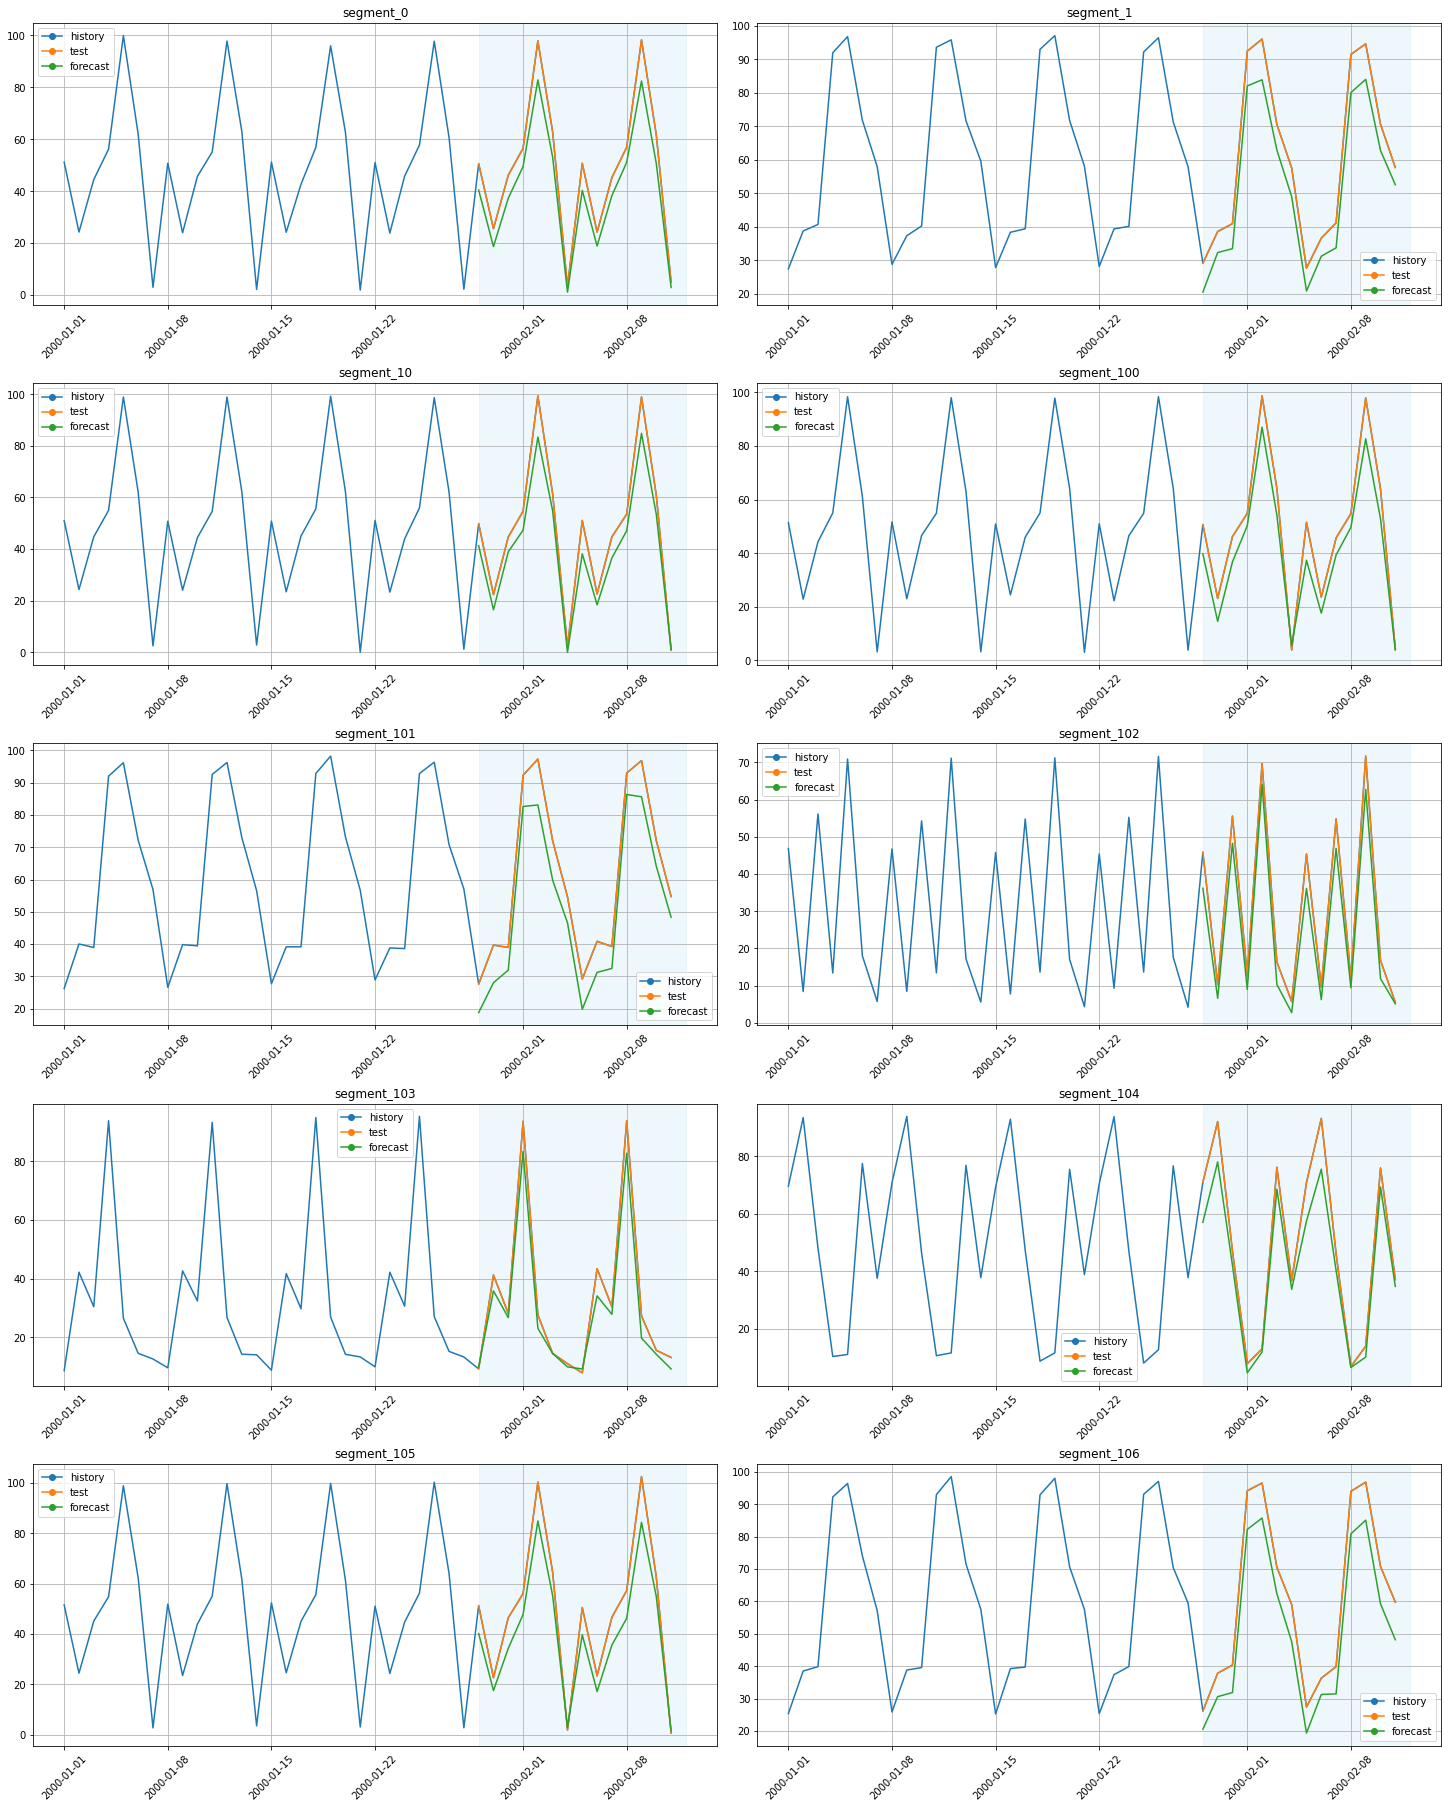

In [18]:
plot_backtest(forecast, ts, segments=ts.segments[:10], history_len="all")

In [19]:
pipeline.trainer_kwargs = dict(max_epochs=2)

In [20]:
pipeline.fit(ts)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name       | Type       | Params
------------------------------------------
0 | RNN        | LSTM       | 280   
1 | projectors | ModuleDict | 176   
------------------------------------------
456       Trainable params
0         Non-trainable params
456       Total params
0.002     Total estimated model params size (MB)
/Users/a.p.chikov/Library/Caches/pypoetry/virtualenvs/etna-ts-5LkX4_TY-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have ma

Training: 0it [00:00, ?it/s]

NNPipeline(horizon = 14, encoder_length = 28, decoder_length = 0, model = DeepStateNetwork(
  (RNN): LSTM(1, 7, batch_first=True)
  (projectors): ModuleDict(
    (prior_mean): Linear(in_features=7, out_features=7, bias=True)
    (prior_std): Sequential(
      (0): Linear(in_features=7, out_features=7, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
    (innovation): Sequential(
      (0): Linear(in_features=7, out_features=7, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
    (noise_std): Sequential(
      (0): Linear(in_features=7, out_features=1, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
), transforms = [], columns_to_add = ['group'], datetime_index = 'datetime_index', train_batch_size = 32, test_batch_size = 1, trainer_kwargs = {'max_epochs': 2}, )

In [21]:
forecast = pipeline.forecast()

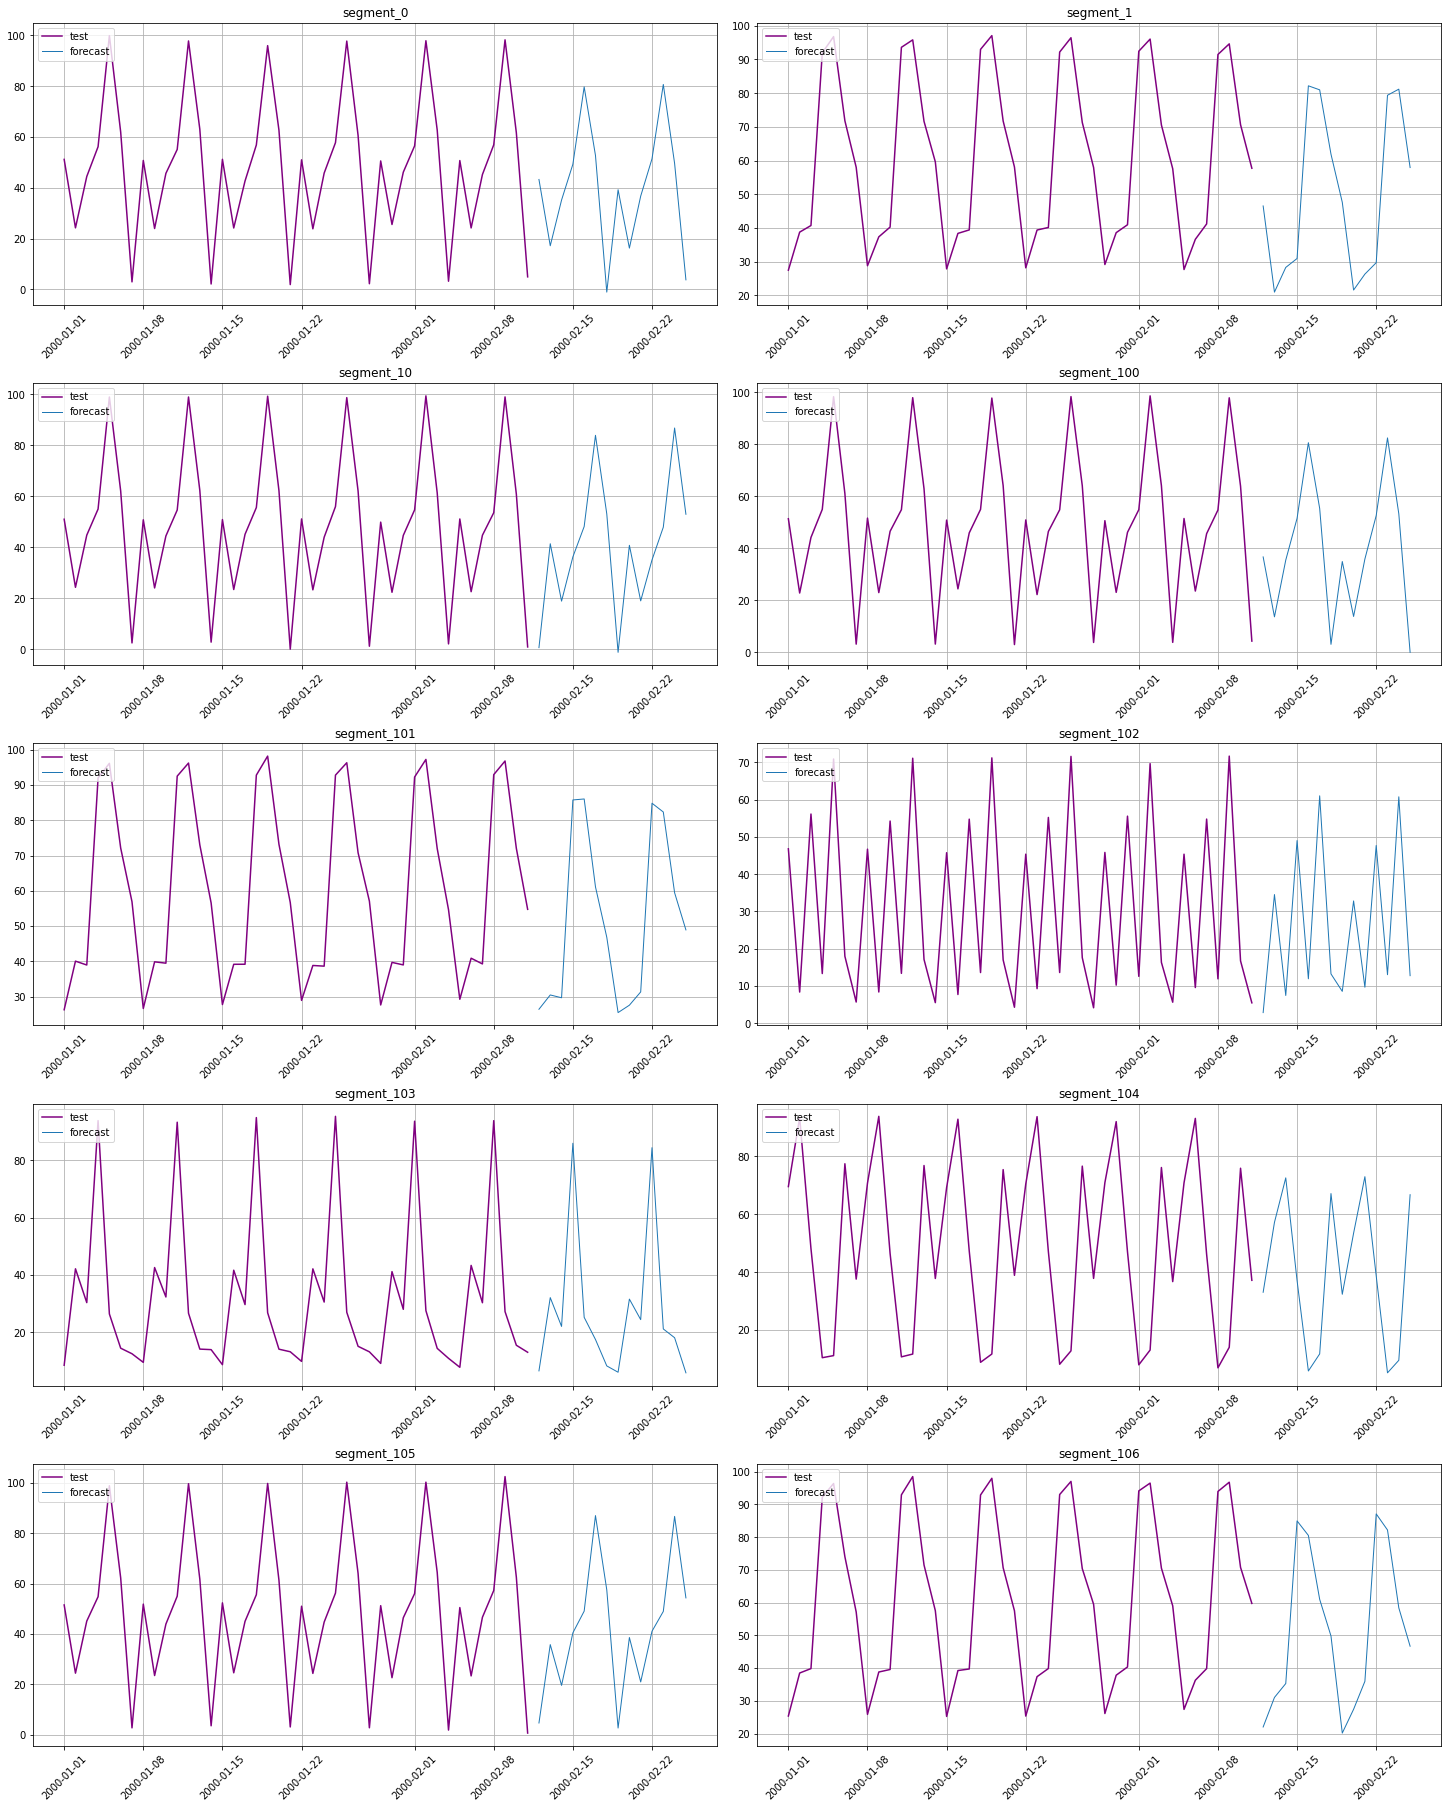

In [22]:
plot_forecast(forecast, ts, segments=ts.segments[:10])

# Параметры

In [23]:
test_dataloader = ts.to_test_dataloader(
            encoder_length=encoder_length,
            decoder_length=0,
            columns_to_add=["group"],
            datetime_index="datetime_index",
            batch_size=1,
        )
test_batch = next(iter(test_dataloader))

In [24]:
with torch.no_grad():
    prior_mean_pred, prior_std_pred, noise_std_pred, innovation_coeff_pred = pipeline.model.get_ssm_parameters(test_batch)

In [25]:
def plot_param(param, param_pred):
    plt.plot(param.reshape(-1), label="true")
    plt.plot(param_pred.numpy().reshape(-1), label="pred")
    plt.legend()

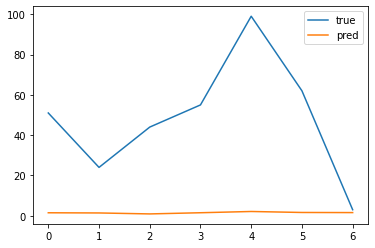

In [26]:
plot_param(prior_mean[0], prior_mean_pred[0])

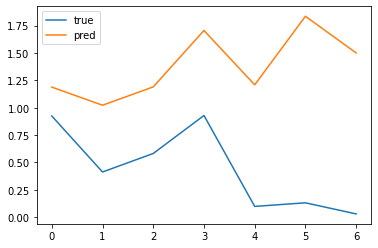

In [27]:
plot_param(prior_std[0], prior_std_pred[0])

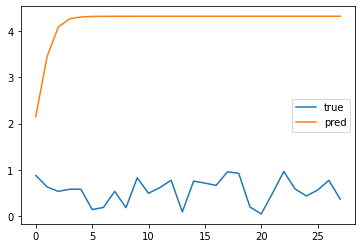

In [28]:
plot_param(noise_std[0][:encoder_length], noise_std_pred[0])

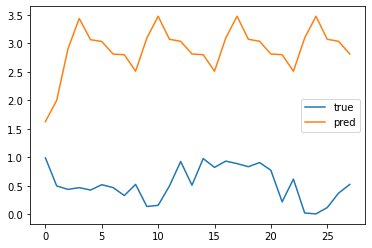

In [29]:
plot_param(inovation_std[0][np.arange(encoder_length), np.arange(encoder_length)%7], innovation_coeff_pred[0][[0, np.arange(encoder_length), np.arange(encoder_length)%7]])